# Stock Price Predictions using Time Series/LSTM

Summary: Predicting the 51st Stock Open Price Based on the previous 50 Stock Open Prices

Import Dependencies/Packages

In [33]:
# Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout
import os
import tensorflow as tf
tf.__version__

'2.10.1'

In [34]:
# Checking if GPU is Registered
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14033498341017055990
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2236245607
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11374389985188343372
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [35]:
# Configuring GPU for Training(Memory Issue)
gpu_devices = tf.config.experimental.list_physical_devices("GPU")
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

Importing the Dataset

In [36]:
stock_data = pd.read_csv(r"C:\Users\steve\Documents\AlgoTrading\(LSTM)Neural Networks for Sentiment and Stock Price Prediction\AAPL.csv")
stock_data.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,67.7142,68.4014,66.8928,67.8542,158168416,AAPL
1,2013-02-11,68.0714,69.2771,67.6071,68.5614,129029425,AAPL
2,2013-02-12,68.5014,68.9114,66.8205,66.8428,151829363,AAPL
3,2013-02-13,66.7442,67.6628,66.1742,66.7156,118721995,AAPL
4,2013-02-14,66.3599,67.3771,66.2885,66.6556,88809154,AAPL


Preprocess our data

In [37]:
# Using only the Open Column
stock_data = stock_data['open'].values # Gives a Series of the Pandas Dataframe
stock_data = stock_data.reshape(-1, 1) # -1 refers to the 1259, reshaping to 1259,1
print(stock_data.shape)
stock_data[:7]

(1259, 1)


array([[67.7142],
       [68.0714],
       [68.5014],
       [66.7442],
       [66.3599],
       [66.9785],
       [65.8714]])

Train/Test Split

In [38]:
train_data = np.array(stock_data[:int(stock_data.shape[0]*0.7)]) # 0:881
test_data = np.array(stock_data[int(stock_data.shape[0]*0.7)-50:]) # 831:1258
# Splitting data into train and test

In [39]:
test_data.shape

(428, 1)

Scaling the Data

In [40]:
# MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

In [41]:
train_data[:5]

array([[0.15550899],
       [0.16002875],
       [0.16546966],
       [0.1432353 ],
       [0.13837263]])

In [42]:
test_data[:5]

array([[0.55694489],
       [0.55896941],
       [0.5516305 ],
       [0.53366283],
       [0.53606695]])

Creating a Structure split the data to X, Y or Feature, Labels

In [43]:
# x represents the 50 previous data/Open Prices
# y represents the 51st data/Open Prices
# We are predicting the 51st data point based on the last 50 data points  
def create_dataset(df):
    x = []
    y = []
    for i in range(50, df.shape[0]):
        x.append(df[i-50:i, 0])
        y.append(df[i,0])
    x = np.array(x)
    y = np.array(y)
    return x, y
    

In [44]:
# Splitting the Train/Test Dataset to X and Y
x_train, y_train = create_dataset(train_data)
x_train[:1] 

array([[0.15550899, 0.16002875, 0.16546966, 0.1432353 , 0.13837263,
        0.14619996, 0.1321915 , 0.12602681, 0.10489581, 0.11077074,
        0.11908522, 0.10095558, 0.10928904, 0.10137187, 0.09043563,
        0.07199725, 0.06057385, 0.08412669, 0.06603248, 0.07561229,
        0.07552245, 0.08609681, 0.07317274, 0.0810899 , 0.09030909,
        0.09667117, 0.12929896, 0.1255384 , 0.11252448, 0.12040496,
        0.13868011, 0.14003654, 0.12380363, 0.11180072, 0.09748478,
        0.07163663, 0.07845043, 0.08277153, 0.06603248, 0.06666515,
        0.06939446, 0.07254007, 0.08269814, 0.08347632, 0.07055098,
        0.06073581, 0.0583861 , 0.03076649, 0.        , 0.00844228]])

In [45]:
x_train[:1].shape

(1, 50)

In [46]:
x_test, y_test = create_dataset(test_data)
x_test[:1]

array([[0.55694489, 0.55896941, 0.5516305 , 0.53366283, 0.53606695,
        0.53859761, 0.55454076, 0.5516305 , 0.54505079, 0.54543039,
        0.54745492, 0.5301199 , 0.53644655, 0.51911154, 0.5212626 ,
        0.51341755, 0.50000506, 0.51658088, 0.51265836, 0.47431887,
        0.47545767, 0.47419234, 0.48773137, 0.49367841, 0.50696437,
        0.50569904, 0.49570294, 0.50962157, 0.51961767, 0.52290752,
        0.52822191, 0.5312587 , 0.53100563, 0.55036517, 0.54758145,
        0.55846328, 0.56403073, 0.56187967, 0.55466729, 0.54188747,
        0.52379326, 0.61799703, 0.59983956, 0.61704804, 0.61983176,
        0.64058317, 0.62489308, 0.63463612, 0.64336689, 0.65918351]])

In [47]:
x_test[:1].shape

(1, 50)

In [48]:
# Reshaping the data
#x_train.shape # We need 831, 50, 1
#y_train.shape # (831, )
x_train = np.reshape(x_train,(x_train.shape[0], x_train.shape[1], 1))
print(x_train.shape)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
print(x_test.shape)

(831, 50, 1)
(378, 50, 1)


Creating the Model

In [49]:
# Create Model Sequence
model = Sequential()
model.add(LSTM(units = 512, return_sequences=True, input_shape = (x_train.shape[1], 1))) #Return Sequences means we can stack another LSTM layer
# Input shape: 50 Time Steps, 1 features(Open Price only)
model.add(Dropout(0.2))
model.add(LSTM(units = 256, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units= 64))
model.add(Dropout(0.15))
model.add(Dense(units = 1)) # One Output: Predicted 51st Stock Price

In [50]:
model.summary() # None is batch size as we have not specified

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 50, 512)           1052672   
                                                                 
 dropout_3 (Dropout)         (None, 50, 512)           0         
                                                                 
 lstm_4 (LSTM)               (None, 50, 256)           787456    
                                                                 
 dropout_4 (Dropout)         (None, 50, 256)           0         
                                                                 
 lstm_5 (LSTM)               (None, 64)                82176     
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                

In [51]:
# Specifying Loss and Optimizer
model.compile(loss = 'mean_squared_error', optimizer = 'adam') # Numerical Problem

Training the Model

In [52]:
# Training the Model
#if (not os.path.exists(r'C:\Users\steve\Documents\AlgoTrading\(LSTM)Neural Networks for Sentiment and Stock Price Prediction\models\stock_predictor.h5')):
    #history = model.fit(x_train, y_train, epochs=50, batch_size=32)
    #model.save(r'C:\Users\steve\Documents\AlgoTrading\(LSTM)Neural Networks for Sentiment and Stock Price Prediction\models\stock_predictor.h5')
history = model.fit(x_train, y_train, epochs=50, batch_size=32)
model.save(r'C:\Users\steve\Documents\AlgoTrading\(LSTM)Neural Networks for Sentiment and Stock Price Prediction\models\stock_predictor.h5')
    

Epoch 1/50
26/26 [==============================] - 9s 33ms/step - loss: 0.0549
Epoch 2/50
26/26 [==============================] - 1s 34ms/step - loss: 0.0067
Epoch 3/50
26/26 [==============================] - 3s 126ms/step - loss: 0.0049
Epoch 4/50
26/26 [==============================] - 3s 110ms/step - loss: 0.0041
Epoch 5/50
26/26 [==============================] - 3s 137ms/step - loss: 0.0041
Epoch 6/50
26/26 [==============================] - 3s 130ms/step - loss: 0.0038
Epoch 7/50
26/26 [==============================] - 3s 128ms/step - loss: 0.0037
Epoch 8/50
26/26 [==============================] - 1s 38ms/step - loss: 0.0034
Epoch 9/50
26/26 [==============================] - 3s 134ms/step - loss: 0.0037
Epoch 10/50
26/26 [==============================] - 3s 130ms/step - loss: 0.0030
Epoch 11/50
26/26 [==============================] - 4s 163ms/step - loss: 0.0033
Epoch 12/50
26/26 [==============================] - 5s 207ms/step - loss: 0.0037
Epoch 13/50
26/26 [=========

In [53]:
# Loading the Model
model = load_model(r'C:\Users\steve\Documents\AlgoTrading\(LSTM)Neural Networks for Sentiment and Stock Price Prediction\models\stock_predictor.h5')

Making Predictions

In [54]:
# Predictions
predictions = model.predict(x_test)
#predictions
# Inverse the Scaling to get original prices
predictions = scaler.inverse_transform(predictions)
predictions

12/12 [==============================] - 2s 26ms/step


array([[107.44337 ],
       [107.94614 ],
       [108.576324],
       [109.15972 ],
       [109.4786  ],
       [109.57151 ],
       [109.72425 ],
       [109.91052 ],
       [110.10551 ],
       [110.20919 ],
       [110.22532 ],
       [110.151146],
       [110.03014 ],
       [109.75474 ],
       [109.39569 ],
       [108.95173 ],
       [108.41077 ],
       [107.86503 ],
       [107.486046],
       [107.52644 ],
       [107.92933 ],
       [108.47714 ],
       [108.89291 ],
       [108.733696],
       [107.84349 ],
       [107.219154],
       [107.31171 ],
       [108.677574],
       [110.990265],
       [113.46656 ],
       [115.14191 ],
       [115.89992 ],
       [116.01388 ],
       [115.80595 ],
       [115.14431 ],
       [114.44535 ],
       [114.03307 ],
       [113.884026],
       [113.82011 ],
       [113.800606],
       [113.84887 ],
       [113.99006 ],
       [114.22141 ],
       [114.56129 ],
       [115.02396 ],
       [115.8706  ],
       [116.86027 ],
       [117.6

Making Plots

range(881, 1259)


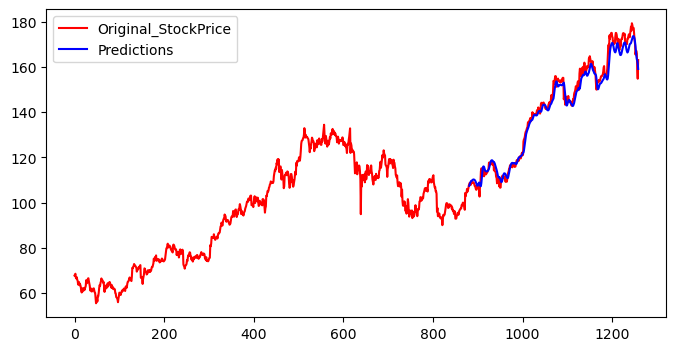

In [55]:
fig,ax = plt.subplots(figsize=(8,4))
plt.plot(stock_data, color = 'red', label = 'Original_StockPrice')
ax.plot(range(len(y_train)+ 50, len(y_train)+50+len(predictions)), predictions, color = 'blue', label = 'Predictions')
plt.legend()
print(range(len(y_train)+ 50, len(y_train)+ 50 + len(predictions)))

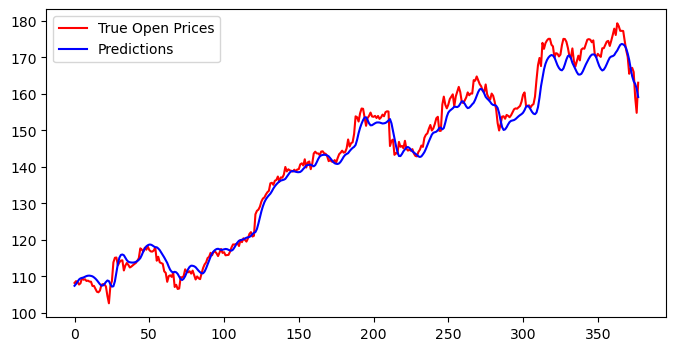

In [56]:
# Getting the Predictions Snapshot
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1)) # Reshape needs 2 dimensions
fig,ax = plt.subplots(figsize=(8,4))
ax.plot(y_test_scaled, color = 'red', label = 'True Open Prices')
plt.plot(predictions, color = 'blue', label = 'Predictions')
plt.legend()